# Explorative analysis on distribution of scholarships

This is an exploration on distribution of scholarships. The data is not publicly available and I have created fantasy labels/names to keep the results anonymised. 

The data-set includes each application for a scholarship. Each application has information such as an applications ID, the name of the applicant, the discipline of the proposed research project, the host university, the project title, and, crucially, the status of the application: whether it is successful or not.

The idea of this analysis is to visualise how the scholarships are distributed across disciplines and universities.

## Cleaning the data

First, I'll import the libraries that I need, and then I will import the data from the excel file.

Throughout the analysis, I have not shown any df.head() or df.sample() so the content of the data remains unknown, because I want to keep the data anonymised. 

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
xl = pd.ExcelFile("scholarships_data_file.xls")

df = xl.parse("Sheet1")

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 10 columns):
Project ID                                      6584 non-null object
Applicant                                       6584 non-null object
Gender                                          6584 non-null object
Status                                          6584 non-null object
Institution                                     6584 non-null object
Primary area                                    6584 non-null object
Sub Discipline                                  6582 non-null object
Second categorisation – if interdisciplinary    1894 non-null object
Project title (searchable)                      6572 non-null object
Unnamed: 9                                      0 non-null float64
dtypes: float64(1), object(9)
memory usage: 514.5+ KB


So, let's see what these columns are:

_Project ID_

Each application is labelled with an ID, saved in the column Project ID in the format: `Scheme Code/YEAR/Application number`, this identifies each application.

This is useful becuase in the assessment process each application remains annonimised. For my purposes, all I want from this feature is the year in which it was submitted.

I will convert this into Year shortly.


_Applicant_

This is the name of the applicant.

_Gender_ 

The applicant's gender. The options are Female, Male or Other. As I will show below, only a very few people identified as other.

_Status_

Because the data includes previous rounds of the funding scheme, there are "past award holders", that is successful people that obtained the scholarship in previous years. Currently successful candidates are "conditional award", and there are other further values for status. In a first approach I will take just two groups: successful and unsuccessful applications.

_Institution_

Which higher education institution is the proposed project going to be held.

_Primary area_

This is a set of broad disciplines, such as computer sciences or study of the human past.

_Sub discipline_

This is a specific discipline, such as history, archeaology or molecular biology.

_Second categorisation... _

Some projects may be inter-/multi- disciplinar, and this column has other related disciplines (that may be from the same primary area than the main discipline or not). I will ignore this for now.

_Project title_

This is the title for the proposed project.

_Unnamed: 9_

This is a glitch in the data mining process.

Due to a glitch in the mining data process, there's an unnamed column that is empty. I will just delete it.

In [84]:
df.drop('Unnamed: 9', axis = 1, inplace = True)

from df.info() we see that two entries do not have a sub-discipline. This is important. The dataset has missing values, but the actual application (submitted in print or though a web-plataform) will have a value. So in this case, I need to see in detail those entries to find out what are and fill out the empty cell.

In [85]:
np.where(pd.isnull(df['Sub Discipline']))

(array([1425, 2900], dtype=int64),)

Looking at those specific applications, I figure out the right value and fill out the dataframe:

In [86]:
df.iloc[1425]['Sub Discipline'] = 'Cell Biology'

In [87]:
df.iloc[2900]['Sub Discipline'] = 'Information Systems'



This command will strip off everything before and after the /:

In [88]:
df['Project ID'] = df['Project ID'].str.split('/').str[1]

Now I will change the name to Year.

In [89]:
df.rename(columns={'Project ID':'Year'}, inplace=True)

In [90]:
df.Year.unique()

array(['2013', '2014', '2015', '2016', '2017', '2018'], dtype=object)

How many institutions and primary areas do we have?

In [91]:
len(df.Institution.unique())

28

In [92]:
len(df['Primary area'].unique())

11

In [93]:
len(df['Sub Discipline'].unique())

108

There are many subdisciplines. In this exploratory analysis I will only consider the `Primary area`. I will leave looking at `Sub Discipline` for future exercises. 

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6584 entries, 0 to 6583
Data columns (total 9 columns):
Year                                            6584 non-null object
Applicant                                       6584 non-null object
Gender                                          6584 non-null object
Status                                          6584 non-null object
Institution                                     6584 non-null object
Primary area                                    6584 non-null object
Sub Discipline                                  6584 non-null object
Second categorisation – if interdisciplinary    1894 non-null object
Project title (searchable)                      6572 non-null object
dtypes: object(9)
memory usage: 463.0+ KB


The features `Second categorisation – if interdisciplinary`  and `Project title (searchable)` will not be necessary, so I will just leave them as they are.

## Analysis first steps

The core of this is to separate the applications between successful and unsucessful. However, there are various values for the feature `Status`. These correspond to past award holders, declined awards, current awards, conditional awards, and so on. I will set a criterion to divide all the existing statuses into two categories: award and failed.

First, let's list the application status possible values:

In [95]:
df.Status.unique()

array(['Past Award Holder', 'Application Unsuccessful', 'Award Declined',
       'Awards Terminated', 'Award Holder', 'Conditional Award',
       'Reserve'], dtype=object)

Now I will create the success (or awarded) and failure/unsuccsesful categories.

In [130]:
Awardee = ['Past Award Holder','Award Holder', 'Conditional Award', 'Awards Terminated']
# All these can be considered successes/awards

Unsuccessful = [ 'Application Unsuccessful', 'Award Declined', 'Reserve']
# All these can be considered failed/unsuccessful 

Total = Awardee+Unsuccessful

I check whether I missed a value for the Status column (I'm sure there are more sophisticated methods to compare lists, but at this time I'm happy and confident enought with the following):

In [97]:
len(Awardee)+len(Unsuccessful)

7

In [98]:
len(df.Status.unique())

7

Now I want to create a dataframe that includes all the project that I consider as successful and one for the unsuccessful:


This will classify all of the data into two groups, because it is a first approach.

Later on, I will come back to this, and see wether applicants applied more than once before being successful, and how that factors in general.

In [99]:
awards = df.loc[(df['Status'].isin(Awardee))]
unsuccessful  = df.loc[(df['Status'].isin(Unsuccessful))]

The basic type of analysis that I will make include comparing the number of applications, the number of awards and a measure of success.

I will use this approach to visualise the data from the point of view of universties, disicplines, gender.

The data has each application and its status, so in order to have a measure of success, I need to define a new variable. I will create a *success rate*, which is calculated as the percentage of successes over the total of applications.

`Success rate =  100 * number of successful applications divided by total number of applications`

The success rate is crucial and I will use it in many different ways: what's the success rate for each disicpline, or for each university, or by gender, etc.

`pandas` [groupby()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) and [count()](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.count.html) will be of great help here.

### Distribution of total applications, awards and the success rate per year

First, I would like to plot for each year the total number of applications (successful and unsuccessful), awards and the associated success rate. This will give a first impression of the distribution of scholarships. Subsequent analysis shall be comapred against this one in order to draw stronger conclusions.



In [100]:
awards_Y = awards.groupby('Year').count()
awards_Y.rename(columns={'Status':'No_Awards'}, inplace=True)
awards_Y.reset_index(inplace=True)

In [101]:
apps_Y = df.groupby(["Year"] ).count()
apps_Y.rename(columns={'Status':'No_Apps'}, inplace=True)
apps_Y.reset_index(inplace=True)


In [102]:
suc_rate_Y = 100*awards.groupby(["Year"] ).count()/df.groupby(["Year"]).count()
suc_rate_Y.rename(columns={'Status':'Suc_Rate'}, inplace=True)
suc_rate_Y.reset_index(inplace=True)

Text(0.5,1.1,'Scholarship 2013-2018')

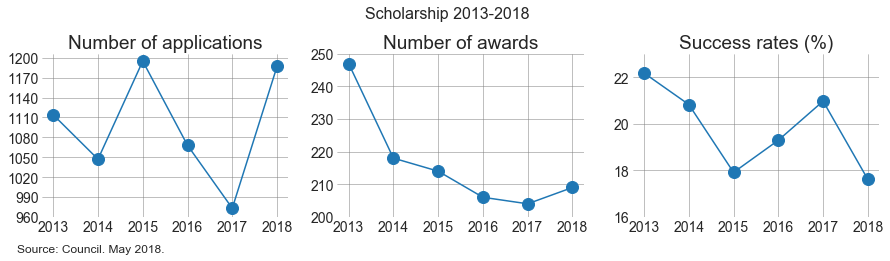

In [103]:
fig, (ax3, ax2, ax1) = plt.subplots(1,3, figsize=(15,3))

ax1.set_facecolor((1, 1, 1))
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.set_facecolor((1, 1, 1))
ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.set_facecolor((1, 1, 1))
ax3.grid(color='gray', linestyle='-', linewidth=0.5)



ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)  


ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)  


ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False)  

ax1.plot(suc_rate_Y.Year, suc_rate_Y.Suc_Rate, marker='o', markersize=12, lw=1.5)

ax2.plot(awards_Y.Year, awards_Y.No_Awards, marker='o', markersize=12, lw=1.5)

ax3.plot(apps_Y.Year, apps_Y.No_Apps, marker='o', markersize=12, lw=1.5)

ax1.set_title('Success rates (%)', fontsize=19)
ax2.set_title('Number of awards', fontsize=19)
ax3.set_title('Number of applications', fontsize=19)


plt.setp(ax1.get_xticklabels(), fontsize=14)
plt.setp(ax1.get_yticklabels(), fontsize=14)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)

start3, end3 = ax3.get_ylim()
ax3.yaxis.set_ticks(np.arange(960, end3+1, 30))

start2, end2 = ax2.get_ylim()
ax2.yaxis.set_ticks(np.arange(200, end2+1, 10))


start1, end1 = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(17, end1+1, 1))

plt.setp(ax1, yticks=np.arange(16, 23, step=2)) #suc_rate

fig.subplots_adjust(hspace=0.35) 
plt.text(-14,14.5, "Source: Council. May 2018.", fontsize=12)   

fig.suptitle("Scholarship 2013-2018", y =1.1, fontsize=16)   

While there was an increase in awards in 2018 compared with 2018, the success rate still decresed! This is because the number of applications in that same period change a lot more. 

It's interesting to appreciate the decreasing trend in number of awards in 2013-2017 and how 2018 was slightly better. 

What happened?
- Is this  a matter of available funding?
- Was the quality of the applications different?
- Were the panels more demanding?



### Analysis by Primary Area

How successful is each primary area, and how does it change in time? 

As I showed before, there are 11 primary areas and the years run 2013-2018.

In [104]:
discipline_suc_rate = 100*awards.groupby([ "Year", "Primary area"]).count()/df.groupby(["Year", "Primary area"] ).count()
discipline_suc_rate.rename(columns={'Applicant':'Suc_Rate'}, inplace=True)
discipline_suc_rate.reset_index(inplace=True)

Now I want to count the number of applications and number of awards for each primary area per year.

In [105]:
discipline_apps = df.groupby(["Year", "Primary area"] ).count()
discipline_apps.rename(columns={'Applicant':'No_Apps'}, inplace=True)
discipline_apps.reset_index(inplace=True)

In [106]:
discipline_awards = awards.groupby(["Year", "Primary area"] ).count()
discipline_awards.rename(columns={'Applicant':'No_Awards'}, inplace=True)
discipline_awards.reset_index(inplace=True)

For creating the following plot, I used an idea from [Randal S. Olson](http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/)'s blog.

Text(-13,-4,'Source: Council. May 2018.')

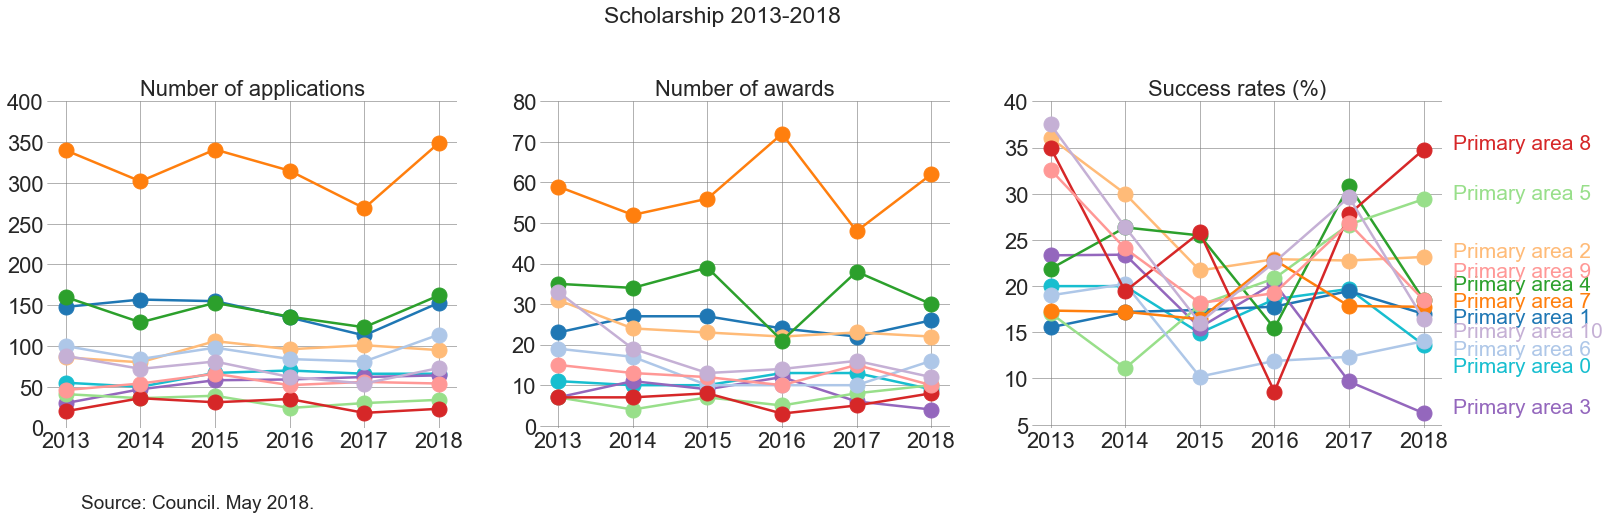

In [107]:
fig, (ax2, ax1, ax3) = plt.subplots(1,3, figsize=(25,6))



ax1.set_facecolor((1, 1, 1))
ax1.grid(color='gray', linestyle='-', linewidth=0.6)
ax2.set_facecolor((1, 1, 1))
ax2.grid(color='gray', linestyle='-', linewidth=0.6)
ax3.set_facecolor((1, 1, 1))
ax3.grid(color='gray', linestyle='-', linewidth=0.6)


ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)  


ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)  


ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False)  

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")

# Tableau20 colors 
tableau20 = [(23, 190, 207), (31, 119, 180),  (255, 187, 120), (148, 103, 189),
             (44, 160, 44), (152, 223, 138), (174, 199, 232), 
             (255, 127, 14),(214, 39, 40), (255, 152, 150),    
             (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141),  (158, 218, 229)]    


  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    


majors = sorted(discipline_apps['Primary area'].unique())


for rank, column in enumerate(majors):    

    
###### Number of applications #####
    data_Ap = discipline_apps[(discipline_apps['Primary area'] == column)]
    ax2.plot(data_Ap.Year, data_Ap.No_Apps, marker='o', markersize=15, lw=2.5, 
                 color=tableau20[rank])
    y_pos_Ap = discipline_apps[(discipline_apps['Primary area'] == column) & 
                                  (discipline_apps['Year'] == '2018')]    
    
###### Number of awards #####
    data_Aw = discipline_awards[(discipline_awards['Primary area'] == column)]
    ax1.plot(data_Aw.Year, data_Aw.No_Awards, marker='o', markersize=15, lw=2.5, 
                 color=tableau20[rank])
    y_pos_Aw = discipline_awards[(discipline_awards['Primary area'] == column) & 
                                  (discipline_awards['Year'] == '2018')]    
###### Success Rate #####
    data_Suc = discipline_suc_rate[(discipline_suc_rate['Primary area'] == column)]
    ax3.plot(data_Suc.Year, data_Suc.Suc_Rate, marker='o', markersize=15, lw=2.5, 
                 color=tableau20[rank])
    y_pos_Suc = discipline_suc_rate[(discipline_suc_rate['Primary area'] == column) & 
                                  (discipline_suc_rate['Year'] == '2018')]    
    x_pos_Suc = 5.4
    if (column == 'Physics'):
        y_pos_Suc['Suc_Rate'].values[0] += 2.5
    if (column == 'Study of the Human Past'):
        y_pos_Suc['Suc_Rate'].values[0] -= 2
    if (column == 'Cultures and Cultural Production'):
        y_pos_Suc['Suc_Rate'].values[0] += 1
    if (column == 'Engineering'):
        y_pos_Suc['Suc_Rate'].values[0] -= 1.5
    if (column == 'Biological Sciences A'):
        y_pos_Suc['Suc_Rate'].values[0] -= 3
    if (column == 'Biological Sciences B'):
        y_pos_Suc['Suc_Rate'].values[0] -= 1
    ax3.text(x_pos_Suc, y_pos_Suc['Suc_Rate'].values[0], 'Primary area ' + str(rank), color=tableau20[rank], fontsize=21)
    
plt.setp(ax1.get_xticklabels(), fontsize=22)
plt.setp(ax1.get_yticklabels(), fontsize=22)
plt.setp(ax2.get_xticklabels(), fontsize=22)
plt.setp(ax2.get_yticklabels(), fontsize=22)
plt.setp(ax3.get_xticklabels(), fontsize=22)
plt.setp(ax3.get_yticklabels(), fontsize=22)

fig.suptitle('Scholarship 2013-2018', y =1.1, fontsize=23)
ax1.set_title('Number of awards', fontsize=22)
ax2.set_title('Number of applications', fontsize=22)
ax3.set_title('Success rates (%)', fontsize=22)


plt.setp(ax3, yticks=np.arange(5, 45, step=5))
plt.setp(ax1, yticks=np.arange(0, 85, step=10))
plt.setp(ax2, yticks=np.arange(0, 450, step=50))



plt.text(-13, -4, "Source: Council. May 2018.", fontsize=19)   

How to analyse this? This plot allows us to easily recognise which primary areas are more populated, and how they change compared to themselves in time and how they are compared with other primary areas.

Ideally, a funding agengy that supports research in all disciplines the same would find a stable success rate for all disicplines. Changes in success rate indicate something interesting to look at in terms of how the applications are evaluated.

One way to view these plots is to consider, for each primary area, the changes in time across each subplot. Consider just two cases:

- Primary area 0 is relatively stable in number of applications. In particular, in 2017 the number of applications decreased. However, the number of awards in 2017 was higher than in 2016. And considering that it has relatively low numbers, this is expressed as a significant change in the success rate in 2016-2017.

- The success rate of Primary area 7 has a peak in 2016. In that year the number of awards grew compared with previous year, and it grew while the number of applications had decreased.

- Primary area 8 seems to change abruptly in success rate. This is due to having low numbers. A change of a few awards/applications can hugely change the success rate if numbers are small.


Another way is to compare the relative order in which the primary areas appear in each subplot.


- Now look at the order in which the primary areas appear. The increase of number of awards for primary area 7 is similar to the decrease of awards for primary area 4 in 2016. However, the number of applications for both primary areas remain relatively stable compared to 2015. Maybe something happened here: maybe the panel of 2016 had a bias 


One can also compare this plots with the global ones made above:
- 2017 had a low number of applications compared with 2016. So, in 2017 there are some primary areas that follow this trend, while others, such as primary area 2, don't.





### Global success rate by Gender

Now I will carry out the same analysis, but in terms of gender. First, I will visualise the successes and failures for each gender for the whole period 2013-2018.

In [108]:
suc_rate_G = 100*awards.groupby(["Gender"] ).count()/df.groupby(["Gender"]).count()
suc_rate_G.rename(columns={'Status':'Suc_Rate'}, inplace=True)
suc_rate_G.reset_index(inplace=True)

In [109]:
apps_G = df.groupby(["Gender"] ).count()
apps_G.rename(columns={'Applicant':'No_Apps'}, inplace=True)
apps_G.reset_index(inplace=True)

In [110]:
awards_G = awards.groupby(["Gender"] ).count()
awards_G.rename(columns={'Status':'No_Awards'}, inplace=True)
awards_G.reset_index(inplace=True)

In [111]:
awards_G = awards.groupby(["Gender"] ).count()
awards_G.rename(columns={'Status':'No_Awards'}, inplace=True)
awards_G.reset_index(inplace=True)

In [112]:
failed_G = unsuccessful.groupby(["Gender"] ).count()
failed_G.rename(columns={'Status':'No_Unsuccessful'}, inplace=True)
failed_G.reset_index(inplace=True)

I used a post by [Kevin Amipara](https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f) that I liked to make pie charts.

Text(-4,-5,'Note: a small number of applicants identified their gender as "Other".\nSource: Council. May 2018.')

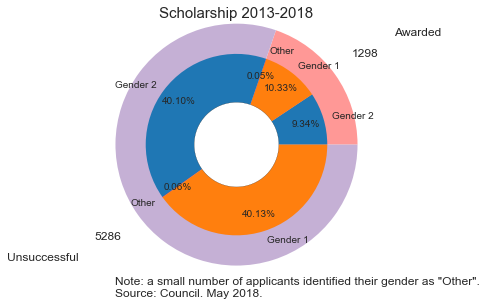

In [113]:

# This is the data that I will plot

labels = ['Awarded', 'Unsuccessful']
explode = (0,0) 
sizes = [1298, 5286]

labels_gender = ['Gender 2', 'Gender 1', 'Other', 'Gender 2','Other', 'Gender 1']
explode_gender = (0,0,0,0, 0,0)
sizes_gender = [615,680,3,  2640,4,2642]

#colors
colors = [(255/255, 152/255, 150/255), (197/255, 176/255, 213/255)]
colors_gender = ['#1F77B4','#FF7F0E', 'r', '#1F77B4','r','#FF7F0E']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
        return '{v:d}'.format(v=val)
    return my_autopct

def make_autopct_pct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
        return '{p:.2f}%'.format(p=pct)
    return my_autopct

#Plot

patches_s, texts_s,autotexts_s  = plt.pie(sizes, labels=labels, colors=colors, startangle=0,
                                          explode=explode,radius=4, autopct=make_autopct(sizes),
                                          pctdistance=1.3, labeldistance=1.6)

patches_g, texts_g,autotexts_g  = plt.pie(sizes_gender,labels=labels_gender, colors=colors_gender,
                                          startangle=0,pctdistance=0.8,labeldistance=1.1, explode=explode_gender,radius=3,
                                          autopct=make_autopct_pct(sizes_gender))

      

#Draw circle
centre_circle = plt.Circle((0,0),1.4,color='black', fc='white',linewidth=0.2)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
    
from matplotlib import font_manager as fm

proptease = fm.FontProperties()
proptease.set_size('large')
plt.setp(autotexts_s, fontproperties=proptease)
plt.setp(texts_s, fontproperties=proptease)

proptease_g = fm.FontProperties()
proptease.set_size('medium')
plt.setp(autotexts_g, fontproperties=proptease_g)
plt.setp(texts_g, fontproperties=proptease)

plt.axis('equal')
plt.tight_layout()

fig.suptitle('Scholarship 2013-2018', fontsize=15)

plt.text(-4, -5, "Note: a small number of applicants identified their gender as \"Other\"." "\n"
         "Source: Council. May 2018.", fontsize=12) 

- This pie chart shows that both the number of applications and awards is relatively balanced between Gender 1 and 2. 

- However, gender 1 takes a little bit more of applications and awards than gender 2.


Next, I will include the success rate for the whole period in barplots:

Text(-5.2,-5,'Note: a small number of applicants identified their the gender as "Other" and are not shown.\nSource: Council. May 2018.')

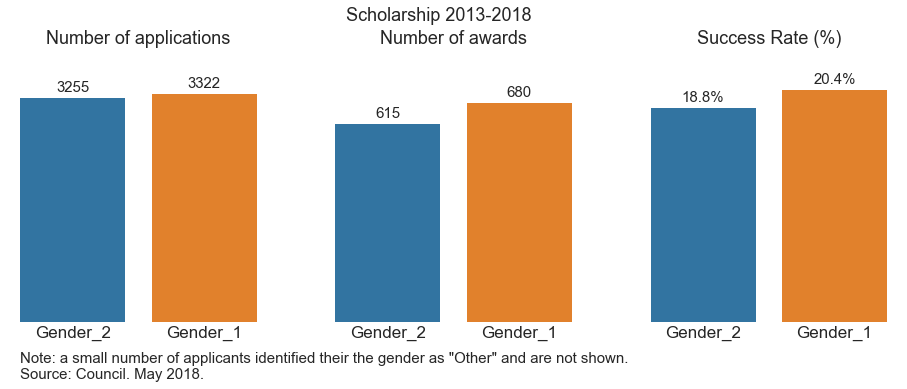

In [114]:
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, (ax2, ax1, ax3) = plt.subplots(1,3, figsize=(16,5))
        
fig.suptitle('Scholarship 2013-2018', y =1, fontsize=18)

colors = ['#1F77B4','#FF7F0E'] #orange Gender_1, blue Gender_2

####################

ax1.set_title('Number of awards', fontsize=18)

sns.countplot(x=awards.Gender, ax=ax1,  palette=colors, order =  ['Gender_2', 'Gender_1'])
 
ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False) 


ax1.get_xaxis().tick_bottom()    
ax1.get_yaxis().tick_left()  
#plt.ylim(0, 30)    
#plt.xlim(2013, 2018)   

plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")


for p in ax1.patches:    
    ax1.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 15)

plt.setp(ax1, yticks=np.arange(0, 850, step=5)) #awards


ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_yticklabels([])
ax1.tick_params(labelsize=17)

##################
ax2.set_title('Number of applications', fontsize=18)

sns.countplot(x=df.Gender, ax=ax2, palette=colors,  order =  ['Gender_2', 'Gender_1'])

ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False) 



ax2.get_xaxis().tick_bottom()    
ax2.get_yaxis().tick_left()  

for p in ax2.patches:    
    ax2.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 15)

plt.setp(ax2, yticks=np.arange(0, 4000, step=50)) #awards

ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.tick_params(labelsize=17)
ax2.set_yticklabels([])


#########


ax3.set_title('Success Rate (%)', fontsize=18)

data = suc_rate_G
sns.barplot(x = 'Gender', y = 'Suc_Rate', data=data, ax=ax3, palette=colors, order =  ['Gender_2', 'Gender_1'])


ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False) 

for p in ax3.patches:    
    ax3.annotate(str(p.get_height())[0:4] + '%', (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize = 15)



plt.setp(ax3, yticks=np.arange(0, 26, step=2)) 
ax3.set_ylabel('')
ax3.set_xlabel('')
ax3.set_yticklabels([])
ax3.tick_params(labelsize=17)

plt.text(-5.2, -5, "Note: a small number of applicants identified their the gender as \"Other\" and are not shown."
         "\n" "Source: Council. May 2018.", fontsize=15)   

- Compared with the pie chart, we can appreciate better how gender 1 perfroms better than 2. 

### Analysis of scholarship distribution by gender per year

In [115]:
suc_rate_Y_G = 100*awards.groupby(["Year","Gender"] ).count()/df.groupby(["Year","Gender"]).count()
suc_rate_Y_G.rename(columns={'Status':'Suc_Rate'}, inplace=True)
suc_rate_Y_G.reset_index(inplace=True)

In [116]:
apps_Y_G = df.groupby(["Year", "Gender"] ).count()
apps_Y_G.rename(columns={'Applicant':'No_Apps'}, inplace=True)
apps_Y_G.reset_index(inplace=True)

In [117]:
awards_Y_G = awards.groupby(["Year","Gender"] ).count()
awards_Y_G.rename(columns={'Status':'No_Awards'}, inplace=True)
awards_Y_G.reset_index(inplace=True)

Text(0.5,1.1,'Scholarship 2013-2018')

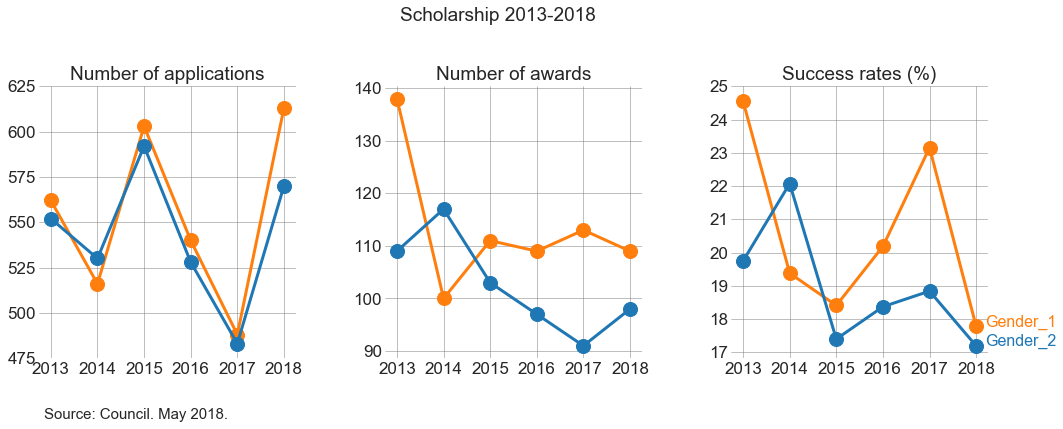

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,5))

ax1.set_facecolor((1, 1, 1))
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.set_facecolor((1, 1, 1))
ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.set_facecolor((1, 1, 1))
ax3.grid(color='gray', linestyle='-', linewidth=0.5)

ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)  


ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)  


ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False)  

colors = ['#FF7F0E','#1F77B4'] #orange Gender_1, blue Gender_2
gender = ['Gender_1', 'Gender_2']

for rank, column in enumerate(gender):    
    # Plot each line separately with its own color, using the Tableau 20    
    # color set in order.    
    data_S = suc_rate_Y_G[(suc_rate_Y_G['Gender']==column)]
    ax3.plot(data_S.Year,data_S.Suc_Rate, marker='o', markersize=14, lw=3, color=colors[rank])
    
    y_pos_Suc = suc_rate_Y_G[(suc_rate_Y_G['Gender']==column) & (suc_rate_Y_G['Year'] == '2018')]    
    ax3.text(5.2, y_pos_Suc['Suc_Rate'].values[0], column, color=colors[rank], fontsize=16)
        
        
        
    data_Aw = awards_Y_G[(awards_Y_G['Gender']==column)]
    ax2.plot(data_Aw.Year, data_Aw.No_Awards, marker='o', markersize=14, lw=3, color=colors[rank])

    data_Ap = apps_Y_G[(apps_Y_G['Gender']==column)]
    ax1.plot(data_Ap.Year, data_Ap.No_Apps, marker='o', markersize=14, lw=3, color=colors[rank])


ax1.set_title('Number of applications', fontsize=19)
ax2.set_title('Number of awards', fontsize=19)
ax3.set_title('Success rates (%)', fontsize=19)


ax1.tick_params(labelsize=17)
ax2.tick_params(labelsize=17)
ax3.tick_params(labelsize=17)



plt.setp(ax3, yticks=np.arange(17, 26, step=1)) 
#plt.setp(ax2, yticks=np.arange(20, 48, step=2)) 
plt.setp(ax1, yticks=np.arange(475, 650, step=25)) 




fig.subplots_adjust(wspace=0.35) 
plt.text(-15,15,"Source: Council. May 2018.", fontsize=15)   

fig.suptitle("Scholarship 2013-2018", y =1.1, fontsize=19)   

I really like these plots. They show even clearer than previous attemts, how the genders perform.

- In most years, there are more awards given to gender 1.
- The gab between genders increased in 2017, were gender 2 decreased the number of awards compared with the previous year, while the number of awards for gender 1 increased compared with the previous year. However, that year (2017), the number of applications was the most balanced.
- It's simple to appreciate how the trens are consistent, in the sense that each year the gender that has more applications also has more awards. The gaps do change, but the overal order does not.


### Global distribution of scholarships across universities

Similar to the case of gender, first I will plot global numbers on the distribution of scholarships across universities. After that, I will carry out the analysis per year.

In [119]:
Universities = ['University 0', 'University 1','University 2', 'University 3' , 'University 4', 'University 5', 'University 6']
Universities = sorted(Universities)

In [120]:
total_uni = df.loc[(df['Status'].isin(Total)) & (df['Institution'].isin(Universities))]

In [121]:
awards_uni = df.loc[(df['Status'].isin(Awardee)) & (df['Institution'].isin(Universities))]

total_uni = df.loc[(df['Status'].isin(Total)) & (df['Institution'].isin(Universities))]

In [122]:
gender_institution_year_suc_rate = awards_uni.groupby(["Gender","Institution"]).count()/total_uni.groupby(["Gender","Institution"] ).count()
gender_institution_year_suc_rate.rename(columns={'Applicant':'Suc_Rate'}, inplace=True)
gender_institution_year_suc_rate.reset_index(inplace=True)

In [123]:
order_unis = pd.DataFrame(data=total_uni.Institution.value_counts())
order_unis.reset_index(inplace=True)

Text(-73,7,'Source: Council. May 2018.')

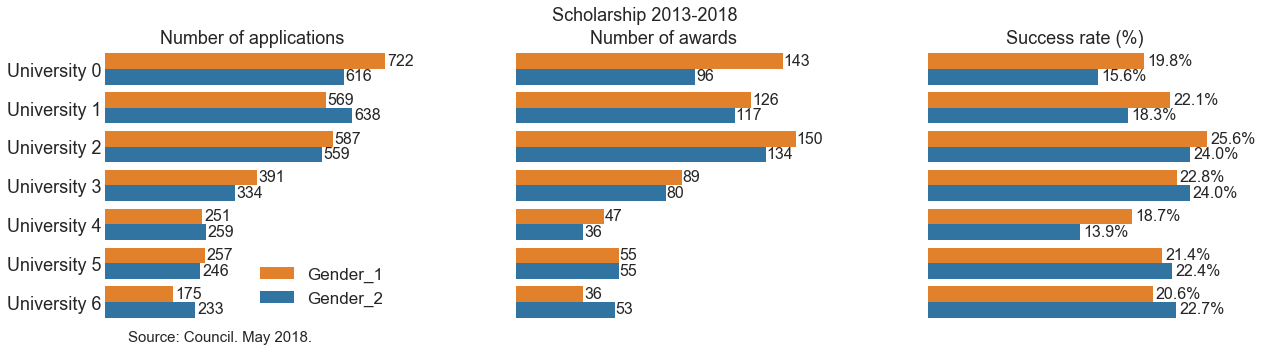

In [124]:
f, (ax1, ax3, ax2) = plt.subplots(1,3, figsize=(20, 5))#, sharex=True)

f.suptitle('Scholarship 2013-2018', y =1, fontsize=18)

plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18

#sns.set(font_scale=1.6)
ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)  

ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)  


ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False)  

colors = ['#FF7F0E','#1F77B4'] #orange Gender_1, blue Gender_2

sns.countplot(y=total_uni.Institution, hue=total_uni.Gender, ax=ax1, palette=colors,
              hue_order=["Gender_1", "Gender_2"], order=order_unis['index'])


# I deliverately set the tick labels 

a=ax1.get_yticks().tolist()
a = ['University 0', 'University 1', 'University 2', 'University 3', 'University 4', 
          'University 5', 'University 6']
ax1.set_yticklabels(a)
ax1.set_xticks([])


plt.style.use('seaborn-white')
sns.set_style("whitegrid", {'axes.grid' : False})

ax1.set_title("Number of applications", fontsize=18)
#plt.setp(ax1, ylabel='')
ax1.set_ylabel("")
ax1.set_xlabel("")

#############################################
sns.barplot(x=100*gender_institution_year_suc_rate.Suc_Rate, y = gender_institution_year_suc_rate.Institution,
            hue=gender_institution_year_suc_rate.Gender, ax=ax2, palette=colors,
              hue_order=["Gender_1", "Gender_2"],
              order=order_unis['index'])



ax2.set_title("Success rate (%)", fontsize=18)
ax2.set_ylabel("")
ax2.set_xlabel("")
plt.setp(ax2, xticks=np.arange(0, 28, step=2))
ax2.set_yticks([])
ax2.set_xticks([])



#############################################
sns.countplot(y=df.loc[df['Status'].isin(Awardee)].Institution, hue=df.loc[df['Status'].isin(Awardee)].Gender,
                ax=ax3,  palette=colors,hue_order=["Gender_1", "Gender_2"],order=order_unis['index'])



ax3.set_title("Number of awards", fontsize=18)
ax3.set_ylabel("")
ax3.set_xlabel("")
ax3.set_yticks([])
ax3.set_xticks([])


############################

ax2.legend_.remove()
ax3.legend_.remove()
ax1.legend(loc='best', fontsize=17)

f.subplots_adjust(wspace=0.4) 

for i in ax1.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax1.text(i.get_width()+5, i.get_y()+.3,np.round(i.get_width(),decimals=2) , fontsize=16)
    

for i in ax2.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(i.get_width()+0.3, i.get_y()+.3, str(np.around(i.get_width(), decimals = 1)) + '%', fontsize=16)
#    print(i)


for i in ax3.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax3.text(i.get_width()+0.3, i.get_y()+.3,np.round(i.get_width(),decimals=2) , fontsize=16)
    

ax1.set_facecolor((1, 1, 1))
ax2.set_facecolor((1, 1, 1))
ax3.set_facecolor((1, 1, 1))


plt.setp(ax1.get_yticklabels(), fontsize=18)
   

plt.text(-73,7,"Source: Council. May 2018.", fontsize=15)   

Here one can identify trends on number of applications and number of awards.
- University 0 has more applications and more awards given to gender 1. The success rate for gender 1 is higher than gender 2.
- However, look at university 4. There we have only 8 more applications for gender 2 than gender 1, but 11 more awards for gender 1. 
- Also, consider University 3. There we see that there are more applications and more awards for gender 1. However, the numbers are such that gender 2 is overall more successful!

### Analysis of scholarship distribution by institution per year

Again,  I create variables of awards, applications and success rate using `goupby`and `count`.

In [125]:
awards_Y_I = awards.groupby(["Year", "Institution"] ).count()
awards_Y_I.rename(columns={'Applicant':'No_Awards'}, inplace=True)
awards_Y_I.reset_index(inplace=True)
awards_Y_I['No_Awards'] = awards_Y_I['No_Awards'].fillna(0)

In [126]:
apps_Y_I = df.groupby(["Year", "Institution"] ).count()
apps_Y_I.rename(columns={'Applicant':'No_Apps'}, inplace=True)
apps_Y_I.reset_index(inplace=True)

In [127]:
suc_rate_Y_I = 100*awards.groupby(["Year","Institution"] ).count()/df.groupby(["Year","Institution"]).count()
suc_rate_Y_I.rename(columns={'Status':'Suc_Rate'}, inplace=True)
suc_rate_Y_I.reset_index(inplace=True)

In [128]:
all_institutions = sorted(df.Institution.unique())

The institutions can be divided into groups: there are universities, colleges and institutes of technology.

It turns out that only the universities have significantly large number of applications and awardees so in most of this analysis I will ignore colleges and institutes of techology.

Text(-13,6,'Source: Council. May 2018.')

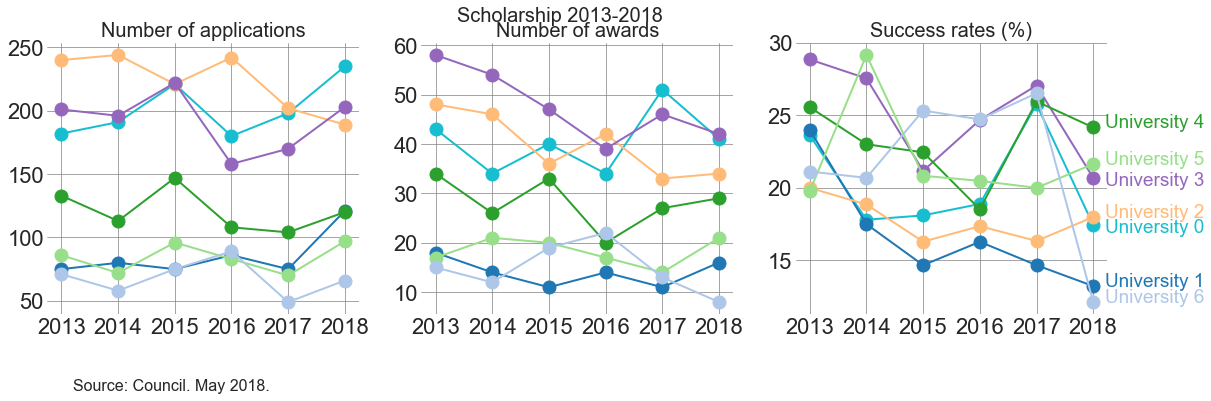

In [129]:
fig, (ax2, ax1, ax3) = plt.subplots(1,3, figsize=(19,5))

ax1.set_facecolor((1, 1, 1))
ax1.grid(color='gray', linestyle='-', linewidth=0.7)
ax2.set_facecolor((1, 1, 1))
ax2.grid(color='gray', linestyle='-', linewidth=0.7)
ax3.set_facecolor((1, 1, 1))
ax3.grid(color='gray', linestyle='-', linewidth=0.7)


ax1.spines["top"].set_visible(False)    
ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False)  


ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)    
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)  


ax3.spines["top"].set_visible(False)    
ax3.spines["bottom"].set_visible(False)    
ax3.spines["right"].set_visible(False)    
ax3.spines["left"].set_visible(False)  


tableau20 = [(23, 190, 207), (31, 119, 180),  (255, 187, 120),     (148, 103, 189),
             (44, 160, 44), (152, 223, 138), (174, 199, 232), (255, 127, 14),(214, 39, 40), (255, 152, 150),    
             (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141),  (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    


majors = sorted(Universities)


for rank, column in enumerate(majors):    
    
###### Number of awards #####
    data_Aw = awards_Y_I[(awards_Y_I['Institution'] == column)]
    ax1.plot(data_Aw.Year, data_Aw.No_Awards, marker='o', markersize=13, lw=2, color=tableau20[rank])

###### Number of applications #####
    data_Ap = apps_Y_I[(apps_Y_I['Institution'] == column)]
    ax2.plot(data_Ap.Year, data_Ap.No_Apps, marker='o', markersize=13, lw=2, 
                 color=tableau20[rank])

###### Success Rate #####
    data_Suc = suc_rate_Y_I[(suc_rate_Y_I['Institution'] == column)]
    ax3.plot(data_Suc.Year, data_Suc.Suc_Rate, marker='o', markersize=13, lw=2, 
                 color=tableau20[rank])
    y_pos_Suc = suc_rate_Y_I[(suc_rate_Y_I['Institution'] == column) & 
                                  (suc_rate_Y_I['Year'] == '2018')]    
    x_pos_Suc = 5.2
    if (column == 'University 3'):
        y_pos_Suc['Suc_Rate'].values[0] -= 0.5
    if (column == 'University 0'):
        y_pos_Suc['Suc_Rate'].values[0] -= 0.5
    ax3.text(x_pos_Suc, y_pos_Suc['Suc_Rate'].values[0], column,color=tableau20[rank], fontsize=19)
   


plt.setp(ax1.get_xticklabels(), fontsize=22)
plt.setp(ax1.get_yticklabels(), fontsize=22)
plt.setp(ax2.get_xticklabels(), fontsize=22)
plt.setp(ax2.get_yticklabels(), fontsize=22)
plt.setp(ax3.get_xticklabels(), fontsize=22)
plt.setp(ax3.get_yticklabels(), fontsize=22)

fig.suptitle('Scholarship 2013-2018', fontsize=20)
ax1.set_title('Number of awards', fontsize=20)
ax2.set_title('Number of applications', fontsize=20)
ax3.set_title('Success rates (%)', fontsize=20)

  
fig.subplots_adjust(hspace=0.35) 

plt.text(-13, 6, "Source: Council. May 2018.", fontsize=16)   

The idea here is similar to how to read the earlier plot that has information on primary area across time.

One can see how the different institutions are ordered, for a year, and compare that order across the different plots.

For example: University 4 has more applications than University 1 in each year. However, in 2016 University 1 obtained more awardees than University 4. University 1 was increasing its awards at a steeper pace than its growth in number of applications.

All universities, except for University 3 and University 5, decreased in applications from 2016 to 2017. In turn, the number of awards increased for University 3, 4 and 5.  That means that the trend was not consistent only for University 4, which had less number of applications but more number of awards comparing 2016 and 2017.





### Distribution of scholarship across universities considering gender

In [130]:
gender_institution_apps = df.groupby(["Year", "Institution", "Gender"] ).count()
gender_institution_apps.rename(columns={'Applicant':'No_apps'}, inplace=True)
gender_institution_apps.reset_index(inplace=True)

In [131]:
awards_gender_institution = awards.groupby([ "Year", "Institution", "Gender"]).count()
awards_gender_institution.rename(columns={'Applicant':'No_Awards'}, inplace=True)
awards_gender_institution.reset_index(inplace=True)

In [132]:
gender_institution_suc_rate = 100*awards.groupby([ "Year", "Institution", "Gender"]).count()/df.groupby(["Year", "Institution", "Gender"] ).count()
gender_institution_suc_rate.rename(columns={'Applicant':'Suc_Rate'}, inplace=True)
gender_institution_suc_rate.reset_index(inplace=True)


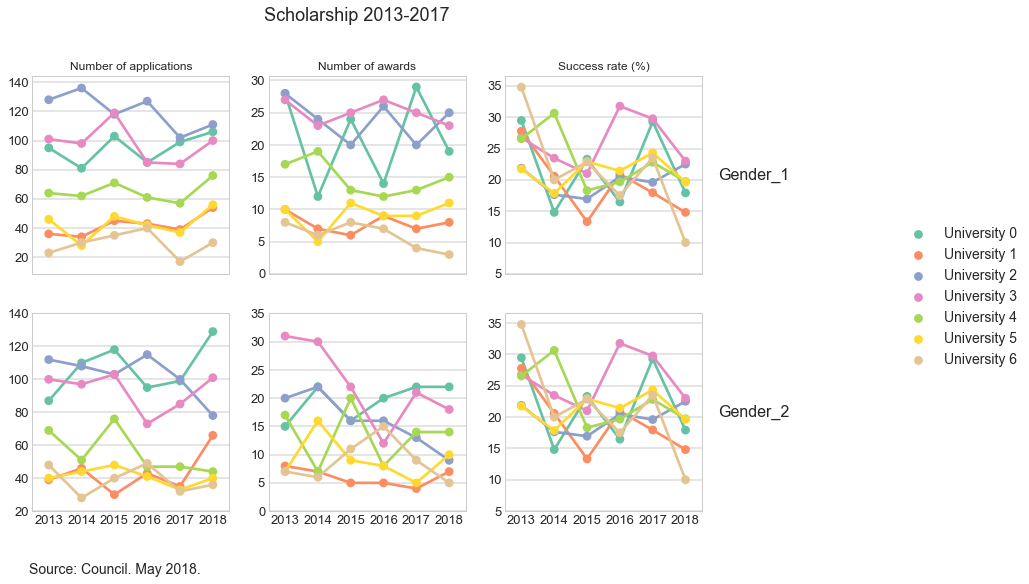

In [134]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True)


# I haven't managed to learn konw how to iterate across axes...

ax1.set_facecolor((1, 1, 1))
ax1.grid(color='gray', linestyle='-', linewidth=0.4)


ax2.set_facecolor((1, 1, 1))
ax2.grid(color='gray', linestyle='-', linewidth=0.4)


ax3.set_facecolor((1, 1, 1))
ax3.grid(color='gray', linestyle='-', linewidth=0.4)


ax4.set_facecolor((1, 1, 1))
ax4.grid(color='gray', linestyle='-', linewidth=0.4)


ax5.set_facecolor((1, 1, 1))
ax5.grid(color='gray', linestyle='-', linewidth=0.4)


ax6.set_facecolor((1, 1, 1))
ax6.grid(color='gray', linestyle='-', linewidth=0.4)



majors = sorted(Universities)

#f.subplots_adjust(hspace=0.3) 


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")

#sns.set(font_scale=1.2)



data_1_apps = gender_institution_apps[(gender_institution_apps['Institution'].isin(majors))
                               & (gender_institution_apps['Gender'] == 'Gender_1')]   

sns.pointplot(x="Year", y="No_apps", hue='Institution', data = data_1_apps, ax=ax1, palette="Set2", 
              hue_order = majors)

data_2_apps = gender_institution_apps[(gender_institution_apps['Institution'].isin(majors))
                                    & (gender_institution_apps['Gender'] == 'Gender_2')]

sns.pointplot(x="Year", y="No_apps", hue='Institution', data = data_2_apps, ax=ax4, palette="Set2",  
              hue_order = majors)

#######################################

data_1_awards = awards_gender_institution[(awards_gender_institution['Institution'].isin(majors))
                                    & (awards_gender_institution['Gender'] == 'Gender_1')]

sns.pointplot(x="Year", y="No_Awards", hue='Institution', data = data_1_awards, ax=ax2, palette="Set2",  
              hue_order = majors)

########

data_2_awards = awards_gender_institution[(awards_gender_institution['Institution'].isin(majors))
                               & (awards_gender_institution['Gender'] == 'Gender_2')]   

sns.pointplot(x="Year", y="No_Awards", hue='Institution', data = data_2_awards, ax=ax5, palette="Set2", 
              hue_order = majors)



#########################################


data_1_Suc_rate = gender_institution_suc_rate[(gender_institution_suc_rate['Institution'].isin(majors))
                                    & (gender_institution_suc_rate['Gender'] == 'Gender_1')]

sns.pointplot(x="Year", y="Suc_Rate", hue='Institution', data = data_1_Suc_rate, ax=ax3, palette="Set2",  
              hue_order = majors) 

data_2_Suc_rate = gender_institution_suc_rate[(gender_institution_suc_rate['Institution'].isin(majors))
                               & (gender_institution_suc_rate['Gender'] == 'Gender_2')]   

sns.pointplot(x="Year", y="Suc_Rate", hue='Institution', data = data_1_Suc_rate, ax=ax6, palette="Set2", 
              hue_order = majors)


#labels
ax1.set(xlabel='', ylabel='')
ax2.set(xlabel='', ylabel='')
ax3.set(xlabel='', ylabel='')
ax4.set(xlabel='', ylabel='')
ax5.set(xlabel='', ylabel='')
ax6.set(xlabel='', ylabel='')


ax1.tick_params(labelsize=13)
ax2.tick_params(labelsize=13)
ax3.tick_params(labelsize=13)
ax4.tick_params(labelsize=13)
ax5.tick_params(labelsize=13)
ax6.tick_params(labelsize=13)


plt.suptitle('Scholarship 2013-2017', y=1, fontsize=18)
ax1.set_title('Number of applications')
ax2.set_title('Number of awards')
ax3.set_title('Success rate (%)')


ax3.text(6, 20,'Gender_1', fontsize=16)
ax6.text(6, 20, 'Gender_2', fontsize=16)

plt.text(-15, -5, "Source: Council. May 2018.", fontsize=14)   

#plt.setp(ax1, yticks=np.arange(10, 175, step=10))
plt.setp(ax4, yticks=np.arange(20, 160, step=20))


plt.setp(ax2, yticks=np.arange(0, 35, step=5))
plt.setp(ax5, yticks=np.arange(0, 40, step=5))


plt.setp(ax3, yticks=np.arange(5, 40, step=5))
plt.setp(ax6, yticks=np.arange(5, 40, step=5))



# I set all but one legend visible=False, knowing that the one I left True will be consistent so the colours 
# because I set the hue_order in each plot!


ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
ax4.legend().set_visible(False)
ax5.legend().set_visible(False)
ax6.legend(handles, labels, loc=(2,0.7), fontsize=14)

In the previous plot, I deliverately changed the labels in legend in order to mask the data. This may be wrong, but this is just a post to show the type of exploratory analysis I carried out.

## Persevere and succeed

There are applicants who applied more than once before being successful. Others were successful in their first attempt. Let us look at these cases.

To be continued...